# DenseNet201 on MURA

Directly using ResNet50 from Keras: https://keras.io/applications/#resnet50

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet201
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import metrics
%load_ext autotime

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 1.88 s


## Loading Data

Loading MURA images

In [3]:
import utils # importing from our utils functions

time: 4.14 s


In [4]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 12.3 s


We can look at the shape of the dataset:

In [5]:
x_train.shape

(36808, 256, 256)

time: 3.62 ms


In [6]:
size = x_train.shape[1]

time: 4.07 ms


Visually inspect an image:

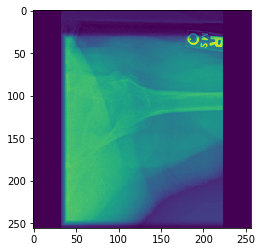

time: 220 ms


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

## Data preparation

reshape the data to `size*size*1`  (1 for channel)

In [8]:
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 1.3 ms


In [9]:
x_train.shape

(36808, 256, 256, 1)

time: 2.95 ms


Convert our data type to float32 and normalize our data values to the range [0, 1].

In [10]:
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

time: 4.28 s


even though we have a 0-1 target, it's easier if we frame it in terms of a 2-class classification task.

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

time: 2.98 ms


In [12]:
y_train.shape

(36808, 2)

time: 3.71 ms


In [13]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[1, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 3.68 ms


In [14]:
datagen.fit(x_train)

time: 4.15 s


## Define model architecture

In [15]:
# declare model
with tf.device('/GPU:0'):
    model = DenseNet201(input_shape=(256, 256, 1), weights=None, classes=2)

time: 17.4 s


In [16]:
model.output_shape

(None, 2)

time: 5.87 ms


In [ ]:
model.summary()

## Compile model

We still need to define the loss and optimization method. Keras has a variety of [loss functions](https://keras.io/losses/) and out-of-the-box [optimizers](https://keras.io/optimizers/) to choose from. For this tutorial we'll use cross-entropy as loss function and [Adam](https://arxiv.org/abs/1412.6980) as our optimizer.

In [18]:
adam = optimizers.Adam(amsgrad=False) #try true later

time: 18.6 ms


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

time: 38.8 ms


## Fitting the model

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=50, verbose=2)

In [21]:
model.save('./trained_models/1_3_densenet201_mura.h5')

time: 1min 49s


We can check how loss and accuracy change over epochs

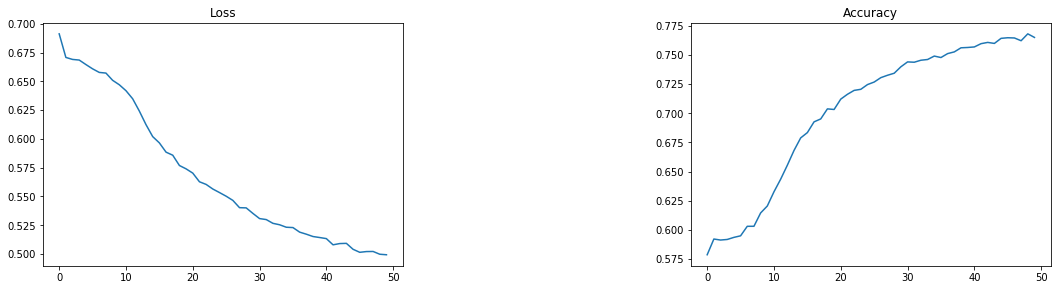

time: 292 ms


In [22]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [13]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_3_densenet201_mura.h5')

time: 17.6 s


## Evaluating our model on the test set - frist 50 epoches

### Loss and Accuracy

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 28 s


In [24]:
score

[0.5923695091646389, 0.7253675319308]

time: 3.3 ms


In [32]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 23 s


In [33]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.61 ms


In [34]:
### Cohen's Kappa

time: 2.17 ms


In [35]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 5.01 ms


In [36]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.89 ms


In [37]:
kappa

0.44016180656608195

time: 2.61 ms


[[1546  121]
 [ 757  773]]


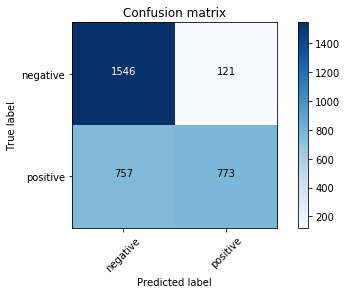

time: 180 ms


In [38]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

# Epoches 50-100

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=50, verbose=2)

In [40]:
model.save('./trained_models/1_3_densenet201_mura_100.h5')

time: 5.94 s


We can check how loss and accuracy change over epochs

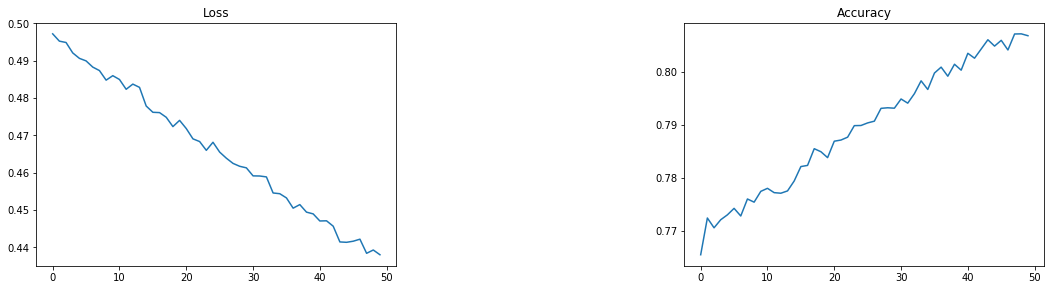

time: 214 ms


In [41]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [15]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_3_densenet201_mura_100.h5')

time: 1min 1s


### Loss and Accuracy

In [42]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 24.4 s


In [43]:
score

[0.6418049865060573, 0.7044103849780609]

time: 4.54 ms


In [44]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 24.4 s


In [45]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.57 ms


In [46]:
### Cohen's Kappa

time: 2.33 ms


In [47]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 3.29 ms


In [48]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 599 µs


In [49]:
kappa

0.4077808756013754

time: 3 ms


[[1193  474]
 [ 471 1059]]


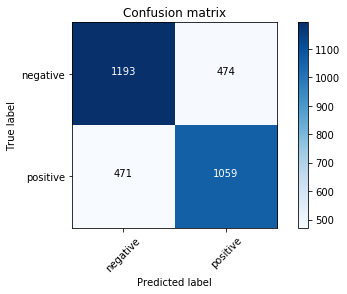

time: 181 ms


In [50]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

# Epoches 100-150 using SGD

In [16]:
sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.95, nesterov=True)

time: 21.9 ms


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

time: 58.2 ms


In [18]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 16, epochs=50, verbose=2)

Epoch 1/50
 - 970s - loss: 0.4287 - acc: 0.8147
Epoch 2/50
 - 933s - loss: 0.4271 - acc: 0.8131
Epoch 3/50
 - 959s - loss: 0.4262 - acc: 0.8144
Epoch 4/50
 - 945s - loss: 0.4316 - acc: 0.8121
Epoch 5/50
 - 952s - loss: 0.4290 - acc: 0.8133
Epoch 6/50
 - 931s - loss: 0.4296 - acc: 0.8129
Epoch 7/50
 - 930s - loss: 0.4307 - acc: 0.8116
Epoch 8/50
 - 951s - loss: 0.4294 - acc: 0.8145
Epoch 9/50
 - 950s - loss: 0.4287 - acc: 0.8148
Epoch 10/50
 - 959s - loss: 0.4285 - acc: 0.8159
Epoch 11/50
 - 968s - loss: 0.4306 - acc: 0.8128
Epoch 12/50
 - 967s - loss: 0.4301 - acc: 0.8151
Epoch 13/50
 - 920s - loss: 0.4305 - acc: 0.8127
Epoch 14/50
 - 940s - loss: 0.4272 - acc: 0.8146
Epoch 15/50
 - 942s - loss: 0.4283 - acc: 0.8138
Epoch 16/50
 - 943s - loss: 0.4259 - acc: 0.8162
Epoch 17/50
 - 943s - loss: 0.4274 - acc: 0.8142
Epoch 18/50
 - 946s - loss: 0.4302 - acc: 0.8125
Epoch 19/50
 - 918s - loss: 0.4296 - acc: 0.8154
Epoch 20/50
 - 947s - loss: 0.4289 - acc: 0.8133
Epoch 21/50
 - 909s - loss: 0

time: 13h 8min 20s


In [19]:
model.save('./trained_models/1_3_densenet201_mura_150.h5')

time: 2min 30s


We can check how loss and accuracy change over epochs

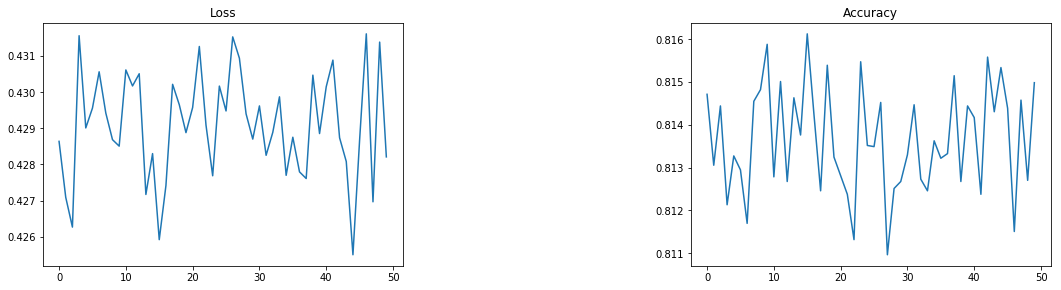

time: 241 ms


In [20]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [21]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_3_densenet201_mura_150.h5')

time: 1min 17s


### Loss and Accuracy

In [22]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 30.1 s


In [23]:
score

[0.6820964780372495, 0.7281826712915888]

time: 5.5 ms


In [24]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 28.7 s


In [25]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 1.71 ms


In [26]:
### Cohen's Kappa

time: 5.05 ms


In [27]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 2.27 ms


In [28]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 908 µs


In [29]:
kappa

0.4447626145347372

time: 2.23 ms


[[1588   79]
 [ 790  740]]


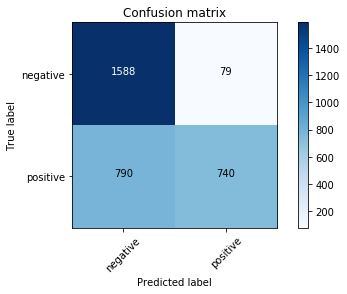

time: 134 ms


In [30]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

# Epoches 150-200 using SGD

In [31]:
sgd = optimizers.SGD(lr=0.1, momentum=0.9, decay=0.9, nesterov=True)

time: 21.1 ms


In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

time: 120 ms


In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 20, epochs=50, verbose=2)

In [34]:
model.save('./trained_models/1_3_densenet201_mura_200.h5')

time: 4min 25s


We can check how loss and accuracy change over epochs

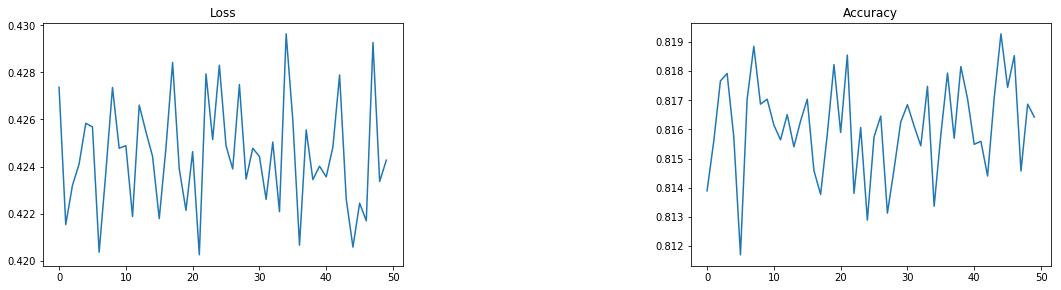

time: 238 ms


In [35]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [36]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_3_densenet201_mura_200.h5')

time: 1min 46s


### Loss and Accuracy

In [37]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 32.4 s


In [38]:
score

[0.6854629304666686, 0.7266187052410544]

time: 2.72 ms


In [39]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 32.7 s


In [40]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 3.1 ms


In [41]:
### Cohen's Kappa

time: 3.14 ms


In [42]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 4.51 ms


In [43]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.41 ms


In [44]:
kappa

0.44121603163867673

time: 12.8 ms


[[1597   70]
 [ 804  726]]


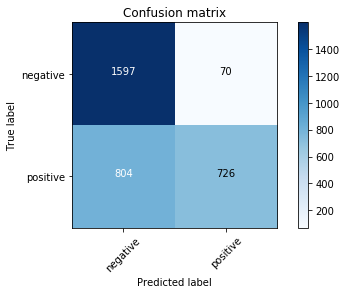

time: 198 ms


In [45]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))

# Epoches 200-250 using SGD

In [46]:
sgd = optimizers.SGD(lr=0.001, momentum=0.9, decay=0.9, nesterov=True)

time: 23.6 ms


In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

time: 113 ms


In [48]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), 
                    steps_per_epoch = len(x_train) / 20, epochs=50, verbose=2)

Epoch 1/50
 - 802s - loss: 0.4249 - acc: 0.8166
Epoch 2/50
 - 747s - loss: 0.4259 - acc: 0.8135
Epoch 3/50
 - 779s - loss: 0.4217 - acc: 0.8176
Epoch 4/50
 - 790s - loss: 0.4269 - acc: 0.8151
Epoch 5/50
 - 774s - loss: 0.4227 - acc: 0.8174
Epoch 6/50
 - 756s - loss: 0.4251 - acc: 0.8180
Epoch 7/50
 - 780s - loss: 0.4216 - acc: 0.8144
Epoch 8/50
 - 761s - loss: 0.4236 - acc: 0.8182
Epoch 9/50
 - 744s - loss: 0.4292 - acc: 0.8125
Epoch 10/50
 - 768s - loss: 0.4190 - acc: 0.8203
Epoch 11/50
 - 761s - loss: 0.4250 - acc: 0.8161
Epoch 12/50
 - 785s - loss: 0.4253 - acc: 0.8160
Epoch 13/50
 - 769s - loss: 0.4276 - acc: 0.8156
Epoch 14/50
 - 766s - loss: 0.4234 - acc: 0.8188
Epoch 15/50
 - 745s - loss: 0.4260 - acc: 0.8147
Epoch 16/50
 - 772s - loss: 0.4241 - acc: 0.8156
Epoch 17/50
 - 739s - loss: 0.4248 - acc: 0.8138
Epoch 18/50
 - 737s - loss: 0.4235 - acc: 0.8185
Epoch 19/50
 - 743s - loss: 0.4175 - acc: 0.8202
Epoch 20/50
 - 763s - loss: 0.4254 - acc: 0.8147
Epoch 21/50
 - 784s - loss: 0

time: 10h 38min 51s


In [49]:
model.save('./trained_models/1_3_densenet201_mura_250.h5')

time: 6min 19s


We can check how loss and accuracy change over epochs

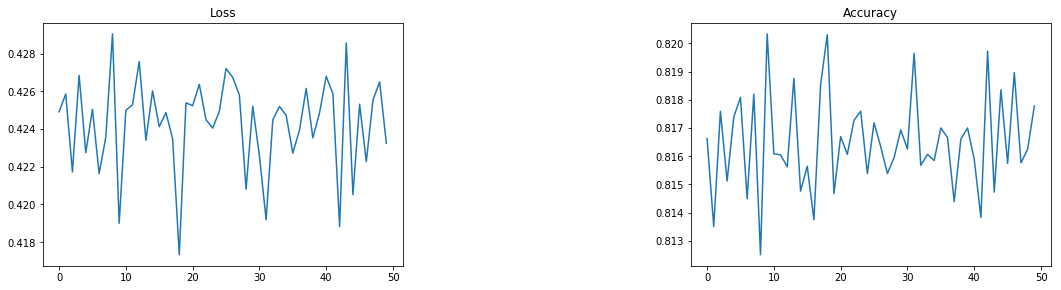

time: 275 ms


In [50]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()

In [51]:
with tf.device('/GPU:1'):
    model = load_model('./trained_models/1_3_densenet201_mura_250.h5')

time: 2min 22s


### Loss and Accuracy

In [52]:
score = model.evaluate(x_test, y_test, verbose=0)

time: 37.8 s


In [53]:
score

[0.6855878042622884, 0.726931498316925]

time: 15.3 ms


In [54]:
# compute predicted y
y_test_hat = model.predict(x_test)

time: 37.8 s


In [55]:
# get actual digit labels
y_test_hat2 = y_test_hat.copy()
y_test_hat2[:, 1] = y_test_hat2[:, 1]
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_test_hat2, axis=1)

time: 2.68 ms


In [56]:
### Cohen's Kappa

time: 4.55 ms


In [57]:
p_observed = (true_label == pred_label).sum()/true_label.shape[0]
p_expected = sum([(true_label == i).sum() * (pred_label == i).sum() / (true_label.shape[0] ** 2) for i in range(2)])

time: 2.77 ms


In [58]:
kappa = (p_observed - p_expected) / (1 - p_expected)

time: 1.53 ms


In [59]:
kappa

0.4419623942875436

time: 2.97 ms


[[1594   73]
 [ 800  730]]


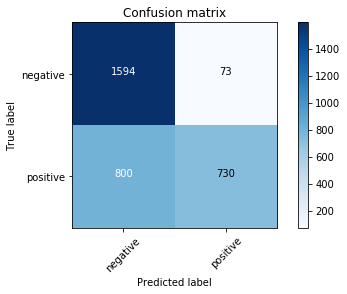

time: 185 ms


In [60]:
utils.plot_confusion_matrix(true_label, pred_label, ('negative', 'positive'))